**Одна из проблем компании Booking — это нечестные отели, которые накручивают себе рейтинг. Одним из способов обнаружения таких отелей является построение модели, которая предсказывает рейтинг отеля. Если предсказания модели сильно отличаются от фактического результата, то, возможно, отель ведёт себя нечестно, и его стоит проверить.**


**Задача - создать модель предсказывающую рейтинг отеля.**

In [1016]:
# импортируем необходимые библиотеки
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import plotly.express as px
%matplotlib inline
from sklearn.model_selection import train_test_split
from geopy.distance import geodesic
from plotly.subplots import make_subplots
import re
from collections import Counter
import nltk
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import string
nltk.download('stopwords')
nltk.download('vader_lexicon')
import category_encoders as ce
from sklearn.feature_selection import f_classif
from sklearn.preprocessing import OneHotEncoder

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

[nltk_data] Error loading punkt: <urlopen error [Errno -3] Temporary
[nltk_data]     failure in name resolution>
[nltk_data] Error loading stopwords: <urlopen error [Errno -3]
[nltk_data]     Temporary failure in name resolution>
[nltk_data] Error loading vader_lexicon: <urlopen error [Errno -3]
[nltk_data]     Temporary failure in name resolution>
/kaggle/input/sf-booking/hotels_test.csv
/kaggle/input/sf-booking/hotels_train.csv
/kaggle/input/sf-booking/submission.csv


In [1017]:
# фиксируем RANDOM_SEED
RANDOM_SEED = 42

In [1018]:
# зафиксируем версию пакетов, для воспроизводимы воспроизводимости экспериментов:
!pip freeze > requirements.txt

In [1019]:
# данные из соревнования
DATA_DIR = '/kaggle/input/sf-booking/'
df_train = pd.read_csv(DATA_DIR+'/hotels_train.csv') # датасет для обучения
df_test = pd.read_csv(DATA_DIR+'hotels_test.csv') # датасет для предсказания
sample_submission = pd.read_csv(DATA_DIR+'/submission.csv') # самбмишн

## **Посмотрим на данные:**

#### * у нас есть тренировочный датасет *df_train*, который содержит 17 признаков и тестовый датасет *df_test*, который содержит те же колонки, что и тренировочный датасет, кроме признака *reviewer_score*, мы его должны предсказать.
#### * *sample_submission* - содержит рейтинг и *id* отеля.

   - **hotel_address** — адрес отеля;
   - **review_date** — дата, когда рецензент разместил соответствующий отзыв;
   - **average_score** — средний балл отеля, рассчитанный на основе последнего комментария за последний год;
   - **hotel_name** — название отеля;
   - **reviewer_nationality** — страна рецензента;
   - **negative_review** — отрицательный отзыв, который рецензент дал отелю;
   - **review_total_negative_word_counts** — общее количество слов в отрицательном отзыв;
   - **positive_review** — положительный отзыв, который рецензент дал отелю;
   - **review_total_positive_word_counts** — общее количество слов в положительном отзыве;
   - **reviewer_score** — оценка, которую рецензент поставил отелю на основе своего опыта;
   - **total_number_of_reviews_reviewer_has_given** — количество отзывов, которые рецензенты дали в прошлом;
   - **total_number_of_reviews** — общее количество действительных отзывов об отеле;
   - **tags** — теги, которые рецензент дал отелю;
   - **days_since_review** — количество дней между датой проверки и датой очистки;
   - **additional_number_of_scoring** — есть также некоторые гости, которые просто поставили оценку сервису, но не оставили отзыв. Это число указывает, сколько там действительных оценок без проверки.
   - **lat** — географическая широта отеля;
   - **lng** — географическая долгота отеля.





In [1020]:
# объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем трейн
df_test['sample'] = 0 # помечаем тест
df_test['reviewer_score'] = 0 # в тесте у нас нет значения reviewer_score, мы его должны предсказать, пока заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [1021]:
data.head(3)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng,sample,reviewer_score
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102,0,0.0
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443,0,0.0
2,Mallorca 251 Eixample 08008 Barcelona Spain,46,11/26/2015,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,5,15,"[' Business trip ', ' Solo traveler ', ' Twin ...",616 day,41.393192,2.161520,0,0.0


In [1022]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

#### С помощью метода info() сделаем предварительную оценку данных. Мы видим, что 8 признаков имеют тип данных object. Это не подходит для обучения модели. Каждый из этих признаков в отдельности  рассмотрим ниже, часть преобразуем в бинарный формат для обучения модели.Так же в двух колонках есть пропуски - это lat и lng. В датасете, который дан для примера их сразу заменили нулями, я сделаю это позже.

In [1023]:
#data['lat'] = data['lat'].fillna(0, inplace=True)
#data['lng'] = data['lng'].fillna(0, inplace=True)

# 1. Исследование и проектирование признаков (FEATURE ENGINEERING):

# - АДРЕС ОТЕЛЯ hotel_address:

#### В том виде как адрес отеля представлен сейчас, он нам не подходит. Но, можно выделить страну, индекс и город.  Создадим новые признаки 'hotel_country', 'hotel_city'и 'zipcode' в которых выделим отдельно страну, город и индекс. 

In [1024]:
#смотрим структуру данных
data['hotel_address'].value_counts()

163 Marsh Wall Docklands Tower Hamlets London E14 9SJ United Kingdom              4789
372 Strand Westminster Borough London WC2R 0JJ United Kingdom                     4256
Westminster Bridge Road Lambeth London SE1 7UT United Kingdom                     4169
Scarsdale Place Kensington Kensington and Chelsea London W8 5SY United Kingdom    3578
7 Pepys Street City of London London EC3N 4AF United Kingdom                      3212
                                                                                  ... 
8 rue Fr d ric Bastiat 8th arr 75008 Paris France                                   12
2 4 Boundary Street Hackney London E2 7DD United Kingdom                            12
Via M Buonarroti 13 Fiera Milano City 20149 Milan Italy                             10
13 Rue Fran ois Ory 92120 Paris France                                              10
Johann Staud Stra e 32 16 Ottakring 1160 Vienna Austria                              8
Name: hotel_address, Length: 1493, dtype: i

In [1025]:
# выделяем страну
data['hotel_country'] = data['hotel_address'].apply(lambda x: x.split()[-1])
data.loc[data['hotel_country'] == 'Kingdom', 'hotel_country'] = 'United Kingdom'
data['hotel_country'].value_counts()

United Kingdom    262301
Spain              60149
France             59928
Netherlands        57214
Austria            38939
Italy              37207
Name: hotel_country, dtype: int64

#### Итак, в нашем датасете собраны отели из 6 стран. 

<AxesSubplot:xlabel='hotel_country', ylabel='count'>

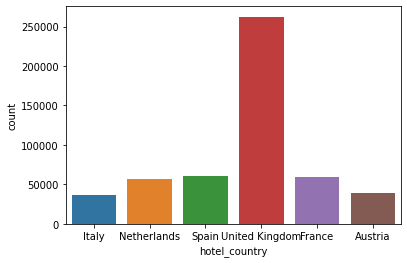

In [1026]:
#визуализируем
sns.countplot(data = data, x='hotel_country')

#### Большинство данных об отелях в Англии

In [1027]:
# выделяем город
data['hotel_city'] = data['hotel_address'].apply(lambda x: x.split()[-5] if x.split()[-1] == 'Kingdom' else x.split()[-2])
data['hotel_city'].value_counts()


London       262301
Barcelona     60149
Paris         59928
Amsterdam     57214
Vienna        38939
Milan         37207
Name: hotel_city, dtype: int64

#### В каждой стране данные представлены только по одному городу. Поскольку количество городов и стран друг друга дублируют, будем пользоваться признаком 'hotel_country'

In [1028]:
# выделяем индекс (индексы испании, италии, нидерландов и австрии состоят из 4 и 5 цифр, 
#у англии - буквенно цифровое обозначение, которе идет перед названием страны и состоит из двух частей
def get_zipcode(arg):
    zipcode = arg.split()
    for i in zipcode:
        if i.isdigit() == True and (len(i) == 5 or len(i) == 4):
            return i
        if 'Kingdom' in zipcode:
            return zipcode[-4] + zipcode[-3]
data['zipcode'] = data['hotel_address'].apply(get_zipcode)

In [1029]:
# смотрим, что получилось
df_country_zipcode = data[['hotel_country', 'zipcode']]
df_country_zipcode.head()

,hotel_country,zipcode
0,Italy,20161
1,Netherlands,1043
2,Spain,08008
3,Italy,20124
4,Netherlands,1012


In [1030]:
#посмотрим сколько всего уникальных значений, т.е районов сосредоточения отелей в таблице
df_country_zipcode.nunique()


hotel_country      6
zipcode          538
dtype: int64

In [1031]:
# справочно посмотрим сколько районов сосредоточения отелей в каждой стране
unique_hotels = df_country_zipcode[['zipcode', 'hotel_country']].drop_duplicates()
result = unique_hotels.groupby('hotel_country')['zipcode'].nunique().reset_index()
result

,hotel_country,zipcode
0,Austria,22
1,France,24
2,Italy,34
3,Netherlands,37
4,Spain,33
5,United Kingdom,389


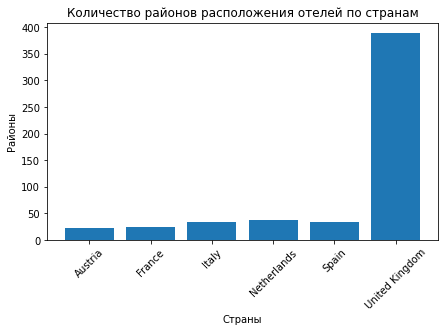

In [1032]:
#визуализируем
plt.figure(figsize=(7,4))
plt.bar(result['hotel_country'], result['zipcode'])

# настройки графика
plt.title('Количество районов расположения отелей по странам')
plt.xlabel('Страны')
plt.ylabel('Районы')
plt.xticks(rotation=45)

# отображаем график
plt.show()

 #### Большинство районов сосредоточения расположения отелей в Англии. Мы не можем сказать, что это отели, т.к по одному индексу может быть несколько отелей. Кроме того для англии мы выделили сложный индекс. Здесь у нас получается, что сколько есть отелей, столько и индексов. 

#### **Итог: мы создали три новых признака 'hotel_city' - город расположения отеля, 'hotel_country' - страна и 'zipcode' - индекс. Мы видим, что два первых признака друг друга дублируют, т.к из одной страны взят только один город. Скорее всего для обучения модели онодин из них нам не нужен.**

# - КООРДИНАТЫ ОТЕЛЯ lat и lng

#### В координатях отеля есть пропуски. Необходимо заполнить их данными. На первоначальном этапе я не стала заполнять эти данные нулями, сделаем это сейчас и изучим данные. Поскольку мы знаем индексы, мы можем координаты заполнить на основании индексов. 

In [1033]:
data['lat'].fillna(0, inplace=True)
data['lng'].fillna(0, inplace=True)

#### Поскольку таблицу полностью рассматривать неудобно, создадим временную таблицу для работы с координатами и изучим данные

In [1034]:
df_cut = data[['hotel_country', 'hotel_name','hotel_address', 'zipcode', 'lat', 'lng']]
df_cut.head()


,hotel_country,hotel_name,hotel_address,zipcode,lat,lng
0,Italy,Hotel Da Vinci,Via Senigallia 6 20161 Milan Italy,20161,45.533137,9.171102
1,Netherlands,Urban Lodge Hotel,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,1043,52.385649,4.834443
2,Spain,Alexandra Barcelona A DoubleTree by Hilton,Mallorca 251 Eixample 08008 Barcelona Spain,08008,41.393192,2.161520
3,Italy,Hotel Principe Di Savoia,Piazza Della Repubblica 17 Central Station 201...,20124,45.479888,9.196298
4,Netherlands,Hotel Esther a,Singel 303 309 Amsterdam City Center 1012 WJ A...,1012,52.370545,4.888644


In [1035]:
df_cut.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   hotel_country  515738 non-null  object 
 1   hotel_name     515738 non-null  object 
 2   hotel_address  515738 non-null  object 
 3   zipcode        515738 non-null  object 
 4   lat            515738 non-null  float64
 5   lng            515738 non-null  float64
dtypes: float64(2), object(4)
memory usage: 23.6+ MB


#### Посмотрим есть ли закономерность в пропусках. После выполнения кода ниже, мы видим, что незаполнены координаты у 17 отелей. 

In [1036]:
df_cut.loc[df_cut['lat'] == 0].value_counts()

hotel_country  hotel_name                                        hotel_address                                                zipcode  lat  lng
Austria        Fleming s Selection Hotel Wien City               Josefst dter Stra e 10 12 08 Josefstadt 1080 Vienna Austria  1080     0.0  0.0    658
               Hotel City Central                                Taborstra e 8 A 02 Leopoldstadt 1020 Vienna Austria          1020     0.0  0.0    563
               Hotel Atlanta                                     W hringer Stra e 33 35 09 Alsergrund 1090 Vienna Austria     1090     0.0  0.0    389
France         Maison Albar Hotel Paris Op ra Diamond            4 rue de la P pini re 8th arr 75008 Paris France             75008    0.0  0.0    290
Austria        Hotel Daniel Vienna                               Landstra er G rtel 5 03 Landstra e 1030 Vienna Austria       1030     0.0  0.0    245
               Hotel Pension Baron am Schottentor                W hringer Stra e 12 09 Alsergrund 10

In [1037]:
# создадим словарь отелей и координат которые не были заполнены, где ключ - название отеля, кортеж координат - это значение. 
# 17 пропущенных значений, мы можем заполнить координаты достаточно точно

coord_dict = {'Austria Trend Hotel Schloss Wilhelminenberg Wien': (48.221415,
  16.2874559),
 'City Hotel Deutschmeister': (48.2211573, 16.3620293),
 'Cordial Theaterhotel Wien': (48.2098335, 16.3475615),
 'Derag Livinghotel Kaiser Franz Joseph Vienna': (48.2462468,
  16.3387236),
 'Fleming s Selection Hotel Wien City': (48.2098335, 16.3475615),
 'Holiday Inn Paris Montmartre': (48.8888806, 2.3331948),
 'Hotel Advance': (41.3832344, 2.162940206993912),
 'Hotel Atlanta': (48.2203284, 16.3558289),
 'Hotel City Central': (48.2278937, 16.3882026),
 'Hotel Daniel Vienna': (48.1888627, 16.3838516356697),
 'Hotel Park Villa': (48.2331682, 16.3470804),
 'Hotel Pension Baron am Schottentor': (48.2212841, 16.3546402),
 'Maison Albar Hotel Paris Op ra Diamond': (48.875248, 2.3233746),
 'Mercure Paris Gare Montparnasse': (48.839701, 2.323519),
 'NH Collection Barcelona Podium': (41.3929354, 2.1758883),
 'Renaissance Barcelona Hotel': (41.3927154, 2.1674921),
 'Roomz Vienna': (48.18672145, 16.420653090404993)}

In [1038]:
# создадим новый признак 'coordinates'
data['coordinates'] = data.apply(lambda row: (row['lat'], row['lng']), axis=1)

In [1039]:
# создадим функцию для замены нулевых значений данными из словаря
def update_coordinates(row):
    if row['coordinates'] == (0.0, 0.0):
        hotel_name = row['hotel_name']
        if hotel_name in coord_dict:
            row['coordinates'] = coord_dict[hotel_name]
    return row

In [1040]:
# применим функцию к нашим данным
data= data.apply(update_coordinates, axis = 1)

#### Теперь, когда у нас все данные заполнены корректно, мы можем узнать расстояние отеля до центра города. 

In [1041]:
# создадим словарь с координатами центра города
city_dict = {'Milan': (45.4641943, 9.1896346),
 'Amsterdam': (52.3730796, 4.8924534),
 'Barcelona': (41.3828939, 2.1774322),
 'London': (51.5073359, -0.12765),
 'Paris': (48.8588897, 2.3200410217200766),
 'Vienna': (48.2083537, 16.3725042)}

In [1042]:
# создаем функцию для вычисления расстояния между двумя точками
def distance_to_city_center(row):
    city = row['hotel_city']
    hotel_coords = row['coordinates']
    city_coords = city_dict[city]
    distance = geodesic(hotel_coords, city_coords).km
    return distance

In [1043]:
# cоздаем новый признак 'distance_to_city_center', расстояние от центра до отеля
data['distance_to_city_center'] = data.apply(distance_to_city_center, axis=1)

In [1044]:
# создаем новый признак 'type_district' чтобы условно разделить отели в зависимости от расстояния до центра
# чтобы в последствии его закодировать
# деление на районы очень условное
# задаем границы для категорий

center_border = 3  # до 3 км от центра
city_border = 10  # от 3 до 10 км от центра

# функция для определения типа района
def get_district_type(distance):
    if distance < center_border:
        return 'historical center'
    elif distance <= city_border:
        return 'city'
    else:
        return 'suburbs'

# создаем новый признак 'type_district'
data['type_district'] = data['distance_to_city_center'].apply(lambda x: get_district_type(x))

In [1045]:
# справочно посмотрим как распределяются отели и районы с предложенным делением по странам
unique_district = data[['hotel_country','hotel_name', 'type_district']].drop_duplicates()

In [1046]:
unique_district['type_district'].value_counts()

historical center    1047
city                  424
suburbs                23
Name: type_district, dtype: int64

In [1047]:
# группировка данных по стране и району
grouped_data = unique_district.groupby(['hotel_country', 'type_district']).size().reset_index(name='count')
grouped_data

,hotel_country,type_district,count
0,Austria,city,37
1,Austria,historical center,121
2,France,city,95
3,France,historical center,363
4,Italy,city,41
5,Italy,historical center,121
6,Netherlands,city,27
7,Netherlands,historical center,78
8,Spain,city,52
9,Spain,historical center,159


In [1048]:
# визуализируем
fig = px.bar(
        data_frame=grouped_data,
        x = 'hotel_country',
        y='count',
        color='type_district',
        barmode='group'      
)
fig.update_layout(title_text="Распределение отелей по районам и странам", title_font_size=20, title_xanchor='center', title_x=0.5)

fig.show()

#### По диаграмме хорошо видно, что в основном, все отели расположены в центратьной части города. И только 23 отеля в Англии, можно отнести к пригороду или окраине. Но опять же данные распределены очень условно. Без учета протяженности каждого города. 

#### Посмотрим на взаимосвязь района и среднего балла. Выделим трейн с предсказанной оценкой, т.к у нас есть 2 оценки отелю. Общий рейтинг - 'reviewer_score' и последня  оценка 'average_score'. Визуально в таблице они разные.

In [1049]:
df_1 = data[data['sample'] == 1]
df_cut = df_1[['hotel_country', 'type_district', 'average_score', 'reviewer_score']]
df_cut.head()

,hotel_country,type_district,average_score,reviewer_score
128935,United Kingdom,historical center,8.4,10.0
128936,United Kingdom,historical center,8.3,6.3
128937,France,historical center,8.9,7.5
128938,France,city,7.5,10.0
128939,Netherlands,city,8.5,9.6


In [1050]:
grouped_cut_score = df_cut.groupby(['hotel_country', 'type_district'])['average_score', 'reviewer_score'].agg(['mean', 'min', 'max'])
grouped_cut_score

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



average_score           reviewer_score       \
                                          mean  min  max           mean  min   
hotel_country  type_district                                                   
Austria        city                   8.434413  7.9  9.1       8.322240  2.5   
               historical center      8.584014  7.7  9.5       8.601746  2.5   
France         city                   8.143672  6.8  9.4       8.088909  2.5   
               historical center      8.496108  7.0  9.8       8.529959  2.5   
Italy          city                   8.062874  6.7  8.9       7.865594  2.5   
               historical center      8.541964  5.2  9.4       8.509001  2.5   
Netherlands    city                   8.322230  7.3  9.1       8.400386  2.5   
               historical center      8.422379  6.4  9.5       8.475385  2.5   
Spain          city                   8.175643  7.0  9.2       8.166795  2.5   
               historical center      8.605382  7.0  9.6       8.648266  2.5   
United Kingdom city                   8.212984  6.6  9.5       8.194443  2.5   
               historical center      8.454920  6.4  9.6       8.448533  2.5   
               suburbs                8.539557  6.9  8.9       8.518168  2.5   

                                        
                                   max  
hotel_country  type_district            
Austria        city               10.0  
               historical center  10.0  
France         city               10.0  
               historical center  10.0  
Italy          city               10.0  
               historical center  10.0  
Netherlands    city               10.0  
               historical center  10.0  
Spain          city               10.0  
               historical center  10.0  
United Kingdom city               10.0  
               historical center  10.0  
               suburbs            10.0

#### Средняя последняя оценка и предсказанная не слишком отличаются, а вот колебания между максимальной и минимальной существенные.

#### **Итог: мы создали три новых признака 'coordinates' - координаты отеля и заполнили недостающие данные, 'distance_to_city_center' - расстояние до центра,  'type_district' - тип района, условно разделив отели по районам.**

# - НАЗВАНИЕ ОТЕЛЯ hotel_name

#### Информации в названии отеля меньше, чем в адресе, но все же посмотрим как распеделяется количество отелей по странам, и попробуем выяснить относятся ли наши отели к сетевым. 

In [1051]:
# смотрим структуру данных и как выглядят названия отелей
data['hotel_name'].value_counts()

Britannia International Hotel Canary Wharf           4789
Strand Palace Hotel                                  4256
Park Plaza Westminster Bridge London                 4169
Copthorne Tara Hotel London Kensington               3578
DoubleTree by Hilton Hotel London Tower of London    3212
                                                     ... 
Hotel Eitlj rg                                         12
Hotel Daniel Paris                                     12
Mercure Paris Porte d Orleans                          10
Hotel Wagner                                           10
Hotel Gallitzinberg                                     8
Name: hotel_name, Length: 1492, dtype: int64

In [1052]:
# справочно посмотрим отелей в каждой стране
data_hotels = data[['hotel_country', 'hotel_name']].drop_duplicates()
result = data_hotels.groupby('hotel_country')['hotel_name'].count()
result

hotel_country
Austria           158
France            458
Italy             162
Netherlands       105
Spain             211
United Kingdom    400
Name: hotel_name, dtype: int64

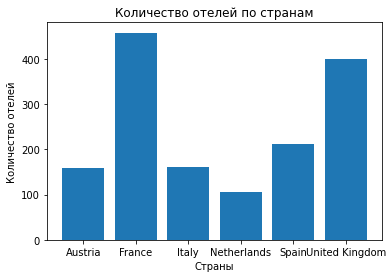

In [1053]:
# визуализируем
plt.bar(result.index, result.values)
plt.title('Количество отелей по странам')
plt.xlabel('Страны')
plt.ylabel('Количество отелей')
plt.show()

#### В нашем датасете самая большая группа отелей во Франции, а отзывов больше всего по отелям из Англии, причем более чем в 4 раза. Интересно, это связано с большим потоком туристов или, может, с языковыми особенностями. Английский язык - международный, возможно, на нем проще оставлять отзывы. А может в нашем датасете не полная информация, и отзывы на других языках просто удалены. 

#### Посмотрим есть ли среди наших отелей те, которые относятся к сетям и можем ли мы это как-то использовать.

In [1054]:
# выделим мировых операторов и возможных по датасету в список
# опять же это деление условное, т.к название отеля может быть записано не полностью или с ошибкой
network_operators = ['Hilton', 'Marriott', 'Accor', 'Ihg', 'Holiday', 
                     'InterContinental', 'Western', 'Radisson', 'Wyndham', 'Choice',
                     'NH', 'Melia', 'Meliá', 'Hyatt','Ibis',
                     'Aldemar', 'Barcelo', 'Domina', 'Four Seasons', 'Golden Tulip',
                     'Iberostar', 'Jumeirah', 'Kempinski', 'Meridien', 'Maritim', 
                     'Sheraton', 'Sofitel', 'Rixos', 'Ritz', 'Mercure', 
                     'Novotel', 'Etap', 'Travelodge', 'Lotte', 'IHG',
                     'Whitbread', 'Wyndham' 'Riu', 'Scandic', 'Millennium', 
                     'Nordic', 'Barony', 'citizenM', 'Metropolitan', 'Barcel', 
                     'Carlson', 'Starwood', 'Jiang', 'Shangri-La', 'Mandarin', 
                     'Fairmont', 'Rosewood', 'Langham' ,'Banyan', 'Taj', 
                     'Swissôtel', 'Swissotel', 'Sofitel', 'Renaissance', 'Westin', 
                     'Regis', 'Aloft', 'Element', 'Leela', 'Oberoi', 
                     'ITC', 'Indian', 'Rocco', 'Belmond', 'Aman', 
                     'COMO', 'Anantara', 'Minor', 'Langham', 'Pacific', 
                     'Park Plaza', 'Red Lion', 'Magnuson', 'Regina']


In [1055]:
# функция для поиска оператора в названии отеля
def find_network_operator(hotel_name):
    for operator in network_operators:
        if re.search(operator, hotel_name, re.IGNORECASE):
            return operator
    return 'no link'

# создание нового признака
data['network_operator'] = data['hotel_name'].apply(find_network_operator)

In [1056]:
# справочно посмотрим распределение сетей
data_network = data[['network_operator', 'hotel_country', 'hotel_name']].drop_duplicates()
result = data_network.groupby('network_operator')['hotel_name'].count()
result

network_operator
Aloft                  1
Barcel                 3
Barcelo               53
COMO                   1
Element                1
Fairmont               1
Four Seasons           3
Golden Tulip           5
Hilton                43
Holiday               25
Hyatt                  8
ITC                    5
Ibis                   2
InterContinental       6
Jumeirah               3
Kempinski              1
Langham                2
Lotte                  1
Mandarin               3
Maritim                2
Marriott              25
Melia                 10
Mercure               48
Meridien               2
Metropolitan           3
Millennium             5
NH                    41
Novotel               25
Park Plaza             9
Radisson              15
Regina                 5
Renaissance            7
Ritz                   5
Rocco                  1
Rosewood               1
Sheraton               3
Sofitel               14
Taj                    2
Western               55
Westin  

#### **Итог: мы создали новый признак 'network_operator', который показывает принадлежит ли отель к сетевым. И к каким. Мало вероятно, что это можно использовать, т.к данные могут содержать ошибки. И из 1494 отелей менее 30% нам удалось отнести к серевым. Но вернусь к этому позже, т.к сетевой и не сетевой может быть дополнительной информацией для обучения модели.**

# - ТЭГИ tags

In [1057]:
# посмотрим как они выглядят и в какой форме представлены
#data['tags'].value_counts()

In [1058]:
# посчитаем уникальные теги
c = Counter()
for tags in data['tags'].apply(lambda s: [x.strip() for x in s[1:-1].replace("'",'').split(',')]):
    for tag in tags:
        c[tag] += 1
len(c)

2428

In [1059]:
# создадим новый признак из очищеных тегов
def rev_func(tags):
    tags = tags[2:-2].strip().split(' \', \' ')
    return tags

data['cleaned_tags'] = data['tags'].apply(rev_func)
data['cleaned_tags'].head()


0    [Leisure trip, Couple, Double Room, Stayed 2 n...
1    [Leisure trip, Group, Triple Room, Stayed 1 ni...
2    [Business trip, Solo traveler, Twin Room, Stay...
3    [Leisure trip, Couple, Ambassador Junior Suite...
4    [Business trip, Solo traveler, Classic Double ...
Name: cleaned_tags, dtype: object

In [1060]:
# 50 самых популярных
tags_list = []
for x in data['cleaned_tags']:
    for tag in x:
        tags_list.append(tag)
        
tags_count = Counter(tags_list)
tags_count.most_common(50)

[('Leisure trip', 417778),
 ('Submitted from a mobile device', 307640),
 ('Couple', 252294),
 ('Stayed 1 night', 193645),
 ('Stayed 2 nights', 133937),
 ('Solo traveler', 108545),
 ('Stayed 3 nights', 95821),
 ('Business trip', 82939),
 ('Group', 65392),
 ('Family with young children', 61015),
 ('Stayed 4 nights', 47817),
 ('Double Room', 35207),
 ('Standard Double Room', 32248),
 ('Superior Double Room', 31393),
 ('Family with older children', 26349),
 ('Deluxe Double Room', 24823),
 ('Double or Twin Room', 22393),
 ('Stayed 5 nights', 20845),
 ('Standard Double or Twin Room', 17483),
 ('Classic Double Room', 16989),
 ('Superior Double or Twin Room', 13570),
 ('2 rooms', 12393),
 ('Stayed 6 nights', 9776),
 ('Standard Twin Room', 9745),
 ('Single Room', 9670),
 ('Twin Room', 8321),
 ('Stayed 7 nights', 7399),
 ('Executive Double Room', 6425),
 ('Classic Double or Twin Room', 6107),
 ('Superior Twin Room', 6064),
 ('Deluxe Double or Twin Room', 5998),
 ('Club Double Room', 5908),
 ('Qu

In [1061]:
# итак, мы можем выделить путешествующих по работе или на отдых
# создадим новый признак 'status_trip', где 1 - отдых (leisure), 2 - бизнес(business), 0 - если ни одного из этих слов нет. 

# Функция для определения статуса по списку хештегов
def get_status(tags):
    # Приводим список хештегов к строке
    tags_str = ' '.join(tags)
    # Ищем слова в тегах, которые могут означать, что поездка не по работе
    if re.search(r'leisure|vacation|holiday|family|pet|couple', tags_str, re.IGNORECASE):
        return 1
    # Ищем слово business без учета регистра
    elif re.search(r'business|biz', tags_str, re.IGNORECASE):
        return 2
    # Если ни одного из этих слов нет, то возвращаем 0
    else:
        return 0

# Создаем новый признак 'status_trip'
data['status_trip'] = data['cleaned_tags'].apply(get_status)

In [1062]:
data['status_trip'].value_counts()

1    444424
2     65427
0      5887
Name: status_trip, dtype: int64

#### У нас 0 присвоено изначально 14 988 записям,  посмотрим их поближе. При выполнении кода ниже, мы видим, что например. у нас остались в тегах такие как: 'Family', 'Pet' - это не могут быть деловые поездки. Поправим функцию. Осталось 11 757. Так же меня смущает слово couple, вот что нам по этому поводу говорит интернет - "Мы используем couple, когда говорим о паре людей, которые состоят в браке или связаны романтическими отношениями. Также couple используется в значении "несколько". Например, принеси мне пару стульев." Источник контента: https://easyspeak.ru/blog/v-chem-raznica-mezhdu/v-chem-raznica-mezhdu-pair-i-couple . Т.е скорее всего это не деловая поездка. Осталось 5 877. больше я не вижу в тегах слов, по которым можно определить какая это поездка. Оставим этот признак так. 


In [1063]:
#data[data['status_trip'] == 0]['cleaned_tags'].head(50)

In [1064]:
# выделим тип путешественников, точнее их предположительное количество: 
# solo - 1, couple - 2, group or family - 3, нет информации - 0. Создадим новый признак 'group_status'

# Функция для определения статуса по списку хештегов
def get_group_status(tags):
    # Приводим список хештегов к строке
    tags_str = ' '.join(tags)
    # Ищем слово solo без учета регистра
    if re.search(r'solo', tags_str, re.IGNORECASE):
        return 1
    # Ищем слово couple без учета регистра
    elif re.search(r'couple', tags_str, re.IGNORECASE):
        return 2
    # Ищем слово group и family без учета регистра
    elif re.search(r'group|family|friends', tags_str, re.IGNORECASE):
        return 3
    # Если ни одного из этих слов нет, то возвращаем 0
    else:
        return 0

# Создаем новый признак 'status_trip'
data['group_status'] = data['cleaned_tags'].apply(get_group_status)

In [1065]:
data['group_status'].value_counts()

2    252294
3    154899
1    108545
Name: group_status, dtype: int64

In [1066]:
# постараемся определить количество комнат в номере
# Single, double - 1, Twin, 2 rooms - 2, Triple - 3, over - 0

# создадим словарь, т.к определяющими могут быть именно словосочетания, используем другой способ определения, более сложный
rooms = ['Single Room', 
        'Double Room', 'Double or Twin Room', '2 rooms', 'Twin Room',
        'Triple Room']

#функция определения количества комнат в номере
def number_of_rooms(tag):
    if rooms[0] in tag or rooms[1] in tag:
        return 1
    # сделаем допущение, что если путешествует один человек, то он остановливается в однокомнатном номере, так же как и couple
    elif 'Solo traveler' in tag or 'Couple' in tag or 'Classic Room' in tag:
        return 1
    elif 'Large Room' in tag or 'Superior King Room' in tag or 'Standard Room' in tag or 'Queen Room' in tag or 'King Room' in tag:
        return 1
    elif rooms[2] in tag or rooms[3] in tag or rooms[4] in tag or 'Twin Guest Room' in tag or 'Family with young children' in tag or 'Family with older children' in tag or 'Junior Suite' in tag:
        return 2
    elif rooms[5] in tag or '3 rooms' in tag:
        return 3
    else: 
        return 0

    
#создание признака количества комнат в номере (из неочищенного признака тэгов в целях поиска словосочетаний в строке)
data['rooms'] = data['tags'].apply(number_of_rooms)


In [1067]:
data['rooms'].value_counts()

1    416640
2     88088
0      8184
3      2826
Name: rooms, dtype: int64

#### После выполнения кода мы видим, что незаполненных значений 140636, посмотрим на эти данные и постараемся уменьшить эту цифру. Код получается написанным вручную, это не очень хорошро, но на мой взгляд достаточно точным. Часто встречается Junior Suite - «junior» переводится как «младший», «меньший» по размеру. Состоит такой номер из одной комнаты, условно поделенной на две зоны – зону отдыха и гостиную. В джуниор сьюте есть все необходимые технические приспособления, такие как спутниковое TV, DVD, доступ в Интернет, музыкальный центр, маленькая кухня и бар. Судя по описанию это фактически двухкомнатный номер. Так же в тегах часто встречается suite, судя по описанию в интернете, это улучшенный номер с больше чем одной комнатой. 

In [1068]:
#data[data['rooms'] == 0]['cleaned_tags'].head(50)

In [1069]:
#функция определения количества ночей
def get_nights(tag):
    for elem in tag:
        if 'night' in elem:
            for i in elem.split():
                if i.isdigit():
                    return i
    else:
        return 0

                
#создание признака количества ночей, проведенных в отелей
data['nights_in_hotel'] = data['cleaned_tags'].apply(get_nights)



In [1070]:
data['nights_in_hotel'].value_counts()


1     193644
2     133936
3      95825
4      47817
5      20843
6       9776
7       7399
8       2502
9       1293
10       889
11       418
12       316
14       247
13       246
0        192
15       117
16        57
17        42
18        33
19        29
21        23
20        19
27        11
30        11
23        10
22        10
25         7
26         7
28         7
24         6
29         5
31         1
Name: nights_in_hotel, dtype: int64

#### На первом, втором и третьем месте у нас путешественники, которые провели всего 1-3 дня в отеле. Кроме того, не распределилось 192 значения, посмотрим на них (код ниже). Не вижу как их можно еще обработать оставим так. 

<AxesSubplot:xlabel='nights_in_hotel', ylabel='count'>

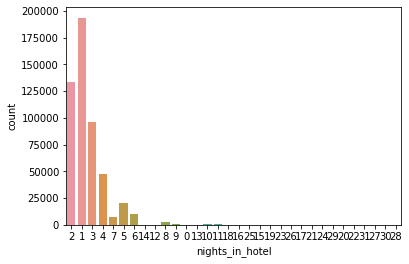

In [1071]:
# визуализируем 
sns.countplot(data = data, x='nights_in_hotel')

In [1072]:
#data[data['nights_in_hotel'] == 0]['cleaned_tags'].tail(50)

In [1073]:
#создание признака использования мобильного телефона при отправке отзывов
data['is_mobile'] = data['cleaned_tags'].apply(lambda x: 1 if 'Submitted from a mobile device' in x else 0)

In [1074]:
# катeгория номера. мы видим, что в тегах, довольно много слов описывающих обычный это стандарнтный номер или номер классом выше
# обозначим 1 - категория класса выше, 0 стандартные и все остальные, которые мы не можем определить ни к какой категории
def get_room_status(tags):
    # Приводим список хештегов к строке
    tags_str = ' '.join(tags)
    # Ищем слова без учета регистра
    if re.search(r'queen|king|superior|delux|executive|suite', tags_str, re.IGNORECASE):
        return 1
    else:
        return 0

# Создаем новый признак 'status_trip'
data['room_status'] = data['cleaned_tags'].apply(get_room_status)


In [1075]:
#data[data['room_status'] == 0]['cleaned_tags'].head(50)

In [1076]:
data['room_status'].value_counts()

0    290786
1    224952
Name: room_status, dtype: int64

#### **Итог: мы создали следующие признаки 'status_trip' - отдых или бизнес командировка, 'group_status' - статус группы - один, пара, семья или группа,  'rooms' - количество комнат в номере проживания, 'nights_in_hotel' - количество ночей и признак 'room_status' - категория номера стандарт или классом выше** 

# - ДАТА ОТЗЫВА review_date

In [1077]:
#преобразование типа признака даты в формат datetime
data['review_date'] = pd.to_datetime(data['review_date'], dayfirst=False)
#признак периода
data['month'] = data['review_date'].dt.month
data['dayofweek'] = data['review_date'].dt.dayofweek
data['day'] = data['review_date'].dt.day
data['year'] = data['review_date'].dt.year

In [1078]:
# посмотрим за какой период взяты отзывы
data['review_date'].min(), data['review_date'].max()

(Timestamp('2015-08-04 00:00:00'), Timestamp('2017-08-03 00:00:00'))

#### В датасете содержатся отзывы начиная с 4 августа 2015 года по 3 августа 2017 года

In [1079]:
data['month'].value_counts()

8     50672
7     49318
5     46490
10    43843
6     42896
4     42883
9     42428
1     42151
3     41110
12    39607
2     38370
11    35970
Name: month, dtype: int64

<AxesSubplot:xlabel='month', ylabel='count'>

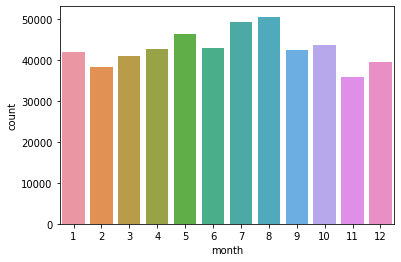

In [1080]:
# визуализируем 
sns.countplot(data = data, x='month')

In [1081]:
data['dayofweek'].value_counts()

1    120948
6     83981
0     81145
3     74508
2     58591
5     51833
4     44732
Name: dayofweek, dtype: int64

<AxesSubplot:xlabel='dayofweek', ylabel='count'>

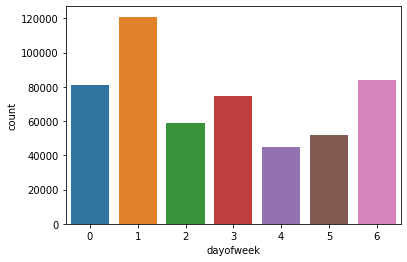

In [1082]:
# визуализируем 
sns.countplot(data = data, x='dayofweek')

In [1083]:
data['day'].value_counts()

5     20230
3     19510
15    18342
10    18275
20    18121
17    17684
24    17661
19    17659
27    17643
2     17465
6     17390
16    16975
12    16953
21    16906
1     16855
26    16753
8     16733
22    16478
28    16321
7     16087
13    16016
29    15961
9     15913
14    15833
18    15782
23    15574
25    15255
4     14779
30    14779
11    13963
31    11842
Name: day, dtype: int64

<AxesSubplot:xlabel='day', ylabel='count'>

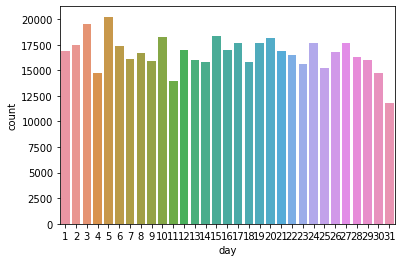

In [1084]:
# визуализируем 
sns.countplot(data = data, x='day')

In [1085]:
data['year'].value_counts()

2016    264403
2017    156808
2015     94527
Name: year, dtype: int64

<AxesSubplot:xlabel='year', ylabel='count'>

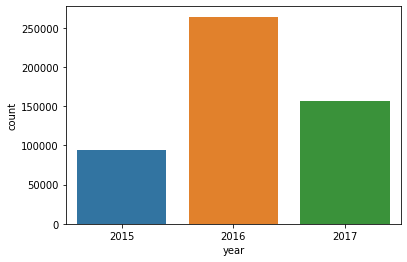

In [1086]:
# визуализируем 
sns.countplot(data = data, x='year')

In [1087]:
# посмотрим на этот признак поближе в разрезе с другими признаками 
df_year = data[['hotel_country', 'year']]
df_year.head()

,hotel_country,year
0,Italy,2017
1,Netherlands,2016
2,Spain,2015
3,Italy,2015
4,Netherlands,2016


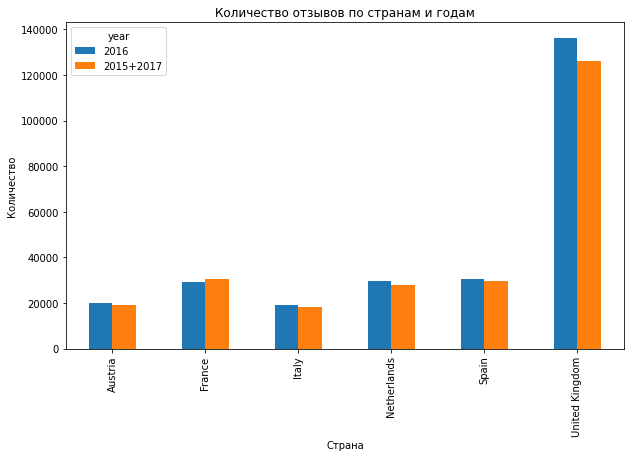

In [1088]:
# т.к у на 2015 и 2017 составляют полный год посмотрим как распределяется количество отзывов за 2 полных года. 
df_year.groupby(['hotel_country', df_year['year'].replace({2015: '2015+2017', 2017: '2015+2017'})])['hotel_country'].count()

# группировка данных
data_year = df_year.groupby(['hotel_country', df_year['year'].replace({2015: '2015+2017', 2017: '2015+2017'})])['hotel_country'].count()

# визуализация
fig, ax = plt.subplots(figsize=(10, 6))
data_year.unstack().plot.bar(ax=ax)

# настройка осей и заголовка
ax.set_xlabel('Страна')
ax.set_ylabel('Количество')
ax.set_title('Количество отзывов по странам и годам')

plt.show()

#### В целом по годам мы видим, что количество отзывов распределяется почти одинаково. За 2016 год отзывов немного больше по всем странам. 

#### **Итог: мы выделили месяц - 'month' и день недели - 'dayofweek' и день - 'day'  и год 'year' из даты.  По месяцам и дням данные распределяются примерно одинаково, а вот отзывы в основном пишут по вторникам), интересно с чем это связано? Наверное, люди успевают отдохнуть и проанализировать поездку. А  вот в пятницу и субботу отзывов пишут меньше всего - это понятно, - некогда). По годам распределение тоже понятно в целом представлены данные за 2 года**

# - СТРАНА РЕЦЕНЗЕНТА reviewer_nationality 

In [1089]:
data['reviewer_nationality'].value_counts()

 United Kingdom               245246
 United States of America      35437
 Australia                     21686
 Ireland                       14827
 United Arab Emirates          10235
                               ...  
 Comoros                           1
 Anguilla                          1
 Tuvalu                            1
 Cape Verde                        1
 Palau                             1
Name: reviewer_nationality, Length: 227, dtype: int64

#### У нас получилось 227 стран. Мы видим, что отели посещают люди со всего мира. Выберем 30 самых популярных стран, откуда приезжают туристы, остальные пометим как "other", таким образом мы подготовим этот признак к кодированию

In [1090]:
top_30_nationalities = data['reviewer_nationality'].value_counts().head(30).index.tolist()
data['top_30_nationalities'] = data['reviewer_nationality'].apply(lambda x: x if x in top_30_nationalities else 'other')

# - ОТЗЫВЫ  - negative_review и positive_review

Первоначально план по обработке отзывов был следующий. Но он оказался долгим и громоздким, а может, это я чего-то недопоняла. Но оставлю это здесь, вдруг, кому-то поможет и прояснит ситуацию в целом. 
1. Очистить данные от лишних символов и привести текст к нижнему регистру.
2. Разбить отзывы на отдельные слова (токенизация).
3. Удалить стоп-слова (например, артикли, предлоги, местоимения), которые не несут смысловой нагрузки.
4. Применить стемминг или лемматизацию для приведения слов к их базовой форме.
5. Создать словарь всех уникальных слов в отзывах.
6. Для каждого отзыва создать вектор, где каждый элемент соответствует количеству употреблений соответствующего слова в отзыве.
7. Добавить векторы для каждого отзыва в таблицу данных, где каждый столбец соответствует одному слову из словаря.

В своей работе я нашла пример использования вот этой библиотеки, код показался более коротким и решение логичным. Оставлю описание шагов так же здесь. 
SentimentIntensityAnalyzer() - это класс из библиотеки nltk.sentiment.vader, который используется для анализа тональности текста на английском языке.
Для использования SentimentIntensityAnalyzer() необходимо выполнить следующие шаги:

1. Установить библиотеку nltk: 
#!pip install nltk
2. Импортировать библиотеку nltk и загрузить необходимые ресурсы:
import nltk
nltk.download('vader_lexicon')
3. Импортировать класс SentimentIntensityAnalyzer:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
4. Создать экземпляр класса SentimentIntensityAnalyzer:
analyzer = SentimentIntensityAnalyzer()
5. Вызвать метод polarity_scores() для анализа тональности текста:
text = "This movie is great!"
scores = analyzer.polarity_scores(text)
print(scores)
Метод polarity_scores() возвращает словарь с четырьмя ключами: 'neg', 'neu', 'pos' и 'compound'. Значение ключа 'compound' является общей оценкой тональности текста, которая может быть от -1 (очень негативная) до 1 (очень позитивная). Значения ключей 'neg', 'neu' и 'pos' представляют собой доли негативных, нейтральных и позитивных слов в тексте соответственно.

In [1091]:
data_review = data[['positive_review', 'review_total_positive_word_counts', 'negative_review', 'review_total_negative_word_counts']]
data_review.head(10)

,positive_review,review_total_positive_word_counts,negative_review,review_total_negative_word_counts
0,Hotel was great clean friendly staff free bre...,62,Would have appreciated a shop in the hotel th...,52
1,No Positive,0,No tissue paper box was present at the room,10
2,Nice welcoming and service,5,Pillows,3
3,Everything including the nice upgrade The Hot...,27,No Negative,0
4,Lovely hotel v welcoming staff,7,No Negative,0
5,The location is perfect if you don t have a l...,26,They don t have free wifi,7
6,Location price It did not cost much more to h...,23,Room generally a bit shabby with some lack of...,35
7,Comphy bed upgraded to executive room with ne...,42,Executive rooms 9th Floor don t have a bath T...,52
8,Its centrality proximity to our destination,7,Pity about the two days of rain,8
9,Didn t like anything about the stay if i had ...,25,Didn t like it at all construction was in pro...,18


In [1092]:
# мы видим, что основная масса отзывов содержит очень мало текста. Посмотрим, какие значения встречаются чаще всего
# приведем тексты отзывов к нижнему регистру
def get_lower_case(text):
    text = text.lower()
    return text

data['negative_review'] = data['negative_review'].apply(get_lower_case)
data['positive_review'] = data['positive_review'].apply(get_lower_case)


In [1093]:
# уберем из этих списков отзывы, которые несут смысловую нагрузку, оставив максимально бессмысленные, создадим два списка

not_negative_list = ['no negative', ' nothing', ' nothing ', ' n a', ' none', ' ',
                     ' all good', ' nothing really', ' no complaints', ' nil', ' nothing really ', ' na',
                     ' nothing at all', ' nothing to dislike', ' nothing at all ', ' none ', ' no complaints ', ' no',
                     ' absolutely nothing ', ' can t think of anything ', ' nothing to dislike ', ' non', ' nothing to complain about ']

not_positive_list = ['no positive', ' nothing', ' nothing ',  ' ']

# предположим, что если отсутствует комментарий в столбце с негативными отзывами, значит, оценка отеля нейтральная, заменим все непонятные значения на neutral
# в случае столбца positive_review сделаем то же самое

negative_mask = data.negative_review.isin(not_negative_list)
positive_mask = data.positive_review.isin(not_positive_list)

data.loc[negative_mask, 'negative_review'] = 'neutral'
data.loc[positive_mask, 'positive_review'] = 'neutral'

# посмотрим, что получилось
data.head(4)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,...,group_status,rooms,nights_in_hotel,is_mobile,room_status,month,dayofweek,day,year,top_30_nationalities
0,Via Senigallia 6 20161 Milan Italy,904,2017-07-21,8.1,Hotel Da Vinci,United Kingdom,would have appreciated a shop in the hotel th...,52,16670,hotel was great clean friendly staff free bre...,...,2,1,2,0,0,7,4,21,2017,United Kingdom
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,2016-12-12,8.6,Urban Lodge Hotel,Belgium,no tissue paper box was present at the room,10,5018,neutral,...,3,3,1,0,0,12,0,12,2016,Belgium
2,Mallorca 251 Eixample 08008 Barcelona Spain,46,2015-11-26,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,pillows,3,351,nice welcoming and service,...,1,1,1,1,0,11,3,26,2015,Sweden
3,Piazza Della Repubblica 17 Central Station 201...,241,2015-10-17,9.1,Hotel Principe Di Savoia,United States of America,neutral,0,1543,everything including the nice upgrade the hot...,...,2,1,1,0,1,10,5,17,2015,United States of America


In [1094]:
# основываясь на оценке настроений каждого пользовательского отзыва, преобразуем признаки негативной и позитивной оценки
# каждый в три новых признака: Положительный, Отрицательный и Нейтральный

sent_analyzer = SentimentIntensityAnalyzer()

negative_polarity_scores = [sent_analyzer.polarity_scores(x) for x in data.negative_review.tolist()]
positive_polarity_scores = [sent_analyzer.polarity_scores(x) for x in data.positive_review.tolist()]

In [1095]:
data['n_negative'] = [x['neg'] for x in negative_polarity_scores]
data['n_neutral'] = [x['neu'] for x in negative_polarity_scores]
data['n_positive'] = [x['pos'] for x in negative_polarity_scores]
data['n_compound'] = [x['compound'] for x in negative_polarity_scores]

data['p_negative'] = [x['neg'] for x in positive_polarity_scores]
data['p_neutral'] = [x['neu'] for x in positive_polarity_scores]
data['p_positive'] = [x['pos'] for x in positive_polarity_scores]
data['p_compound'] = [x['compound'] for x in positive_polarity_scores]


In [1096]:
data.head(3)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,...,year,top_30_nationalities,n_negative,n_neutral,n_positive,n_compound,p_negative,p_neutral,p_positive,p_compound
0,Via Senigallia 6 20161 Milan Italy,904,2017-07-21,8.1,Hotel Da Vinci,United Kingdom,would have appreciated a shop in the hotel th...,52,16670,hotel was great clean friendly staff free bre...,...,2017,United Kingdom,0.129,0.747,0.125,-0.0554,0.0,0.671,0.329,0.9615
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,2016-12-12,8.6,Urban Lodge Hotel,Belgium,no tissue paper box was present at the room,10,5018,neutral,...,2016,Belgium,0.216,0.784,0.000,-0.2960,0.0,1.000,0.000,0.0000
2,Mallorca 251 Eixample 08008 Barcelona Spain,46,2015-11-26,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,pillows,3,351,nice welcoming and service,...,2015,Sweden,0.000,1.000,0.000,0.0000,0.0,0.260,0.740,0.6908


# 2.  УДАЛЕНИЕ ПРИЗНАКОВ

#### Можно сказать, что удаление признаков я разбила на два этапа. Первый, удаляем лишние столбцы после преобразования данных и образования новых признаков, второй - удалим категориальные признаки после кодирования данных. Итак, мы преобразовали часть категориальных признаков посмотрим, что у нас получилось и удалим лишние столбцы. 

In [1097]:
#data.info()

In [1098]:
data.drop(['hotel_city', 'hotel_address', 'reviewer_nationality', 'review_date', 'negative_review', 'positive_review', 'tags', 'lat', 'lng', 'days_since_review'], axis=1 , inplace=True)

#### Удаляем следующие признаки:
- 'hotel_city' - т.к он дублирует 'hotel_country'
- 'hotel_address' - признак полезный и очень громоздкий. Всю необходимую информацию из него мы получили
- 'reviewer_nationality' - мы выделили из этого признака топ 30 стран, откуда приезжают туристы, так он нам больше подходит для кодирования
- 'review_date' - мы выделили из этого признака интересующие нас периоды, признак можно удалить
- 'negative_review', 'positive_review' - мы их обработали с помощью специальной библиотеки, которая описывает тональность отзыва цифрами
- 'tags' - из тегов мы так же выудили всю информацию
- 'lat', 'lng' - долгота и широта 
- 'days_since_review' - мне кажется,  этот признак мог бы быть полезен, если бы мы знали дату, когда путешественник останавливался в отеле, тогда можно было бы проанализировать через сколько времени после поездки был написан отзыв


In [1099]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 35 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515738 non-null  int64  
 1   average_score                               515738 non-null  float64
 2   hotel_name                                  515738 non-null  object 
 3   review_total_negative_word_counts           515738 non-null  int64  
 4   total_number_of_reviews                     515738 non-null  int64  
 5   review_total_positive_word_counts           515738 non-null  int64  
 6   total_number_of_reviews_reviewer_has_given  515738 non-null  int64  
 7   sample                                      515738 non-null  int64  
 8   reviewer_score                              515738 non-null  float64
 9   hotel_country                               515738 non-null  object 
 

# 3.  КОДИРОВАНИЕ  ПРИЗНАКOB

In [1100]:
# кодируем страну отеля
data['hotel_country'] = data['hotel_country'].astype('category')
data['hotel_country_code'] = data['hotel_country'].cat.codes
# проверяем, что получилось
#data[['hotel_country', 'hotel_country_code']]

In [1101]:
# кодируем тип района 
data['type_district'] = data['type_district'].astype('category')
data['type_district_code'] = data['type_district'].cat.codes
# проверяем, что получилось
#data[['type_district', 'type_district_code']]

In [1102]:
# кодируем тип оператора 
data['network_operator'] = data['network_operator'].astype('category')
data['type_network_operator'] = data['network_operator'].cat.codes
# проверяем, что получилось
#data[['network_operator', 'type_network_operator']]

In [1103]:
# кодируем количество ночей
data['nights_in_hotel'] = data['nights_in_hotel'].astype('category')
data['type_nights_in_hotel'] = data['nights_in_hotel'].cat.codes
# проверяем, что получилось
#data[['nights_in_hotel', 'type_nights_in_hotel']]

In [1104]:
# кодируем топ 30 национальностей
data['top_30_nationalities'] = data['top_30_nationalities'].astype('category')
data['type_top_30_nationalities'] = data['top_30_nationalities'].cat.codes
# проверяем, что получилось
#data[['top_30_nationalities', 'type_top_30_nationalities']]

In [1105]:
# удаляем оставшиеся категориальные признаки
data.drop(['hotel_country', 'hotel_name', 'zipcode', 'coordinates', 'type_district', 'cleaned_tags', 'network_operator', 'nights_in_hotel', 'top_30_nationalities'], axis=1 , inplace=True)

In [1106]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 31 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515738 non-null  int64  
 1   average_score                               515738 non-null  float64
 2   review_total_negative_word_counts           515738 non-null  int64  
 3   total_number_of_reviews                     515738 non-null  int64  
 4   review_total_positive_word_counts           515738 non-null  int64  
 5   total_number_of_reviews_reviewer_has_given  515738 non-null  int64  
 6   sample                                      515738 non-null  int64  
 7   reviewer_score                              515738 non-null  float64
 8   distance_to_city_center                     515738 non-null  float64
 9   status_trip                                 515738 non-null  int64  
 

# 4. СТАНДАРТИЗАЦИЯ ПРИЗНАКОВ

In [1107]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)
data_scaled = pd.DataFrame(data_scaled, columns=data.columns)

# 5. КОРРЕЛЯЦИЯ ПРИЗНАКОВ

Text(0.5, 1.0, 'Корреляция Спирмена')

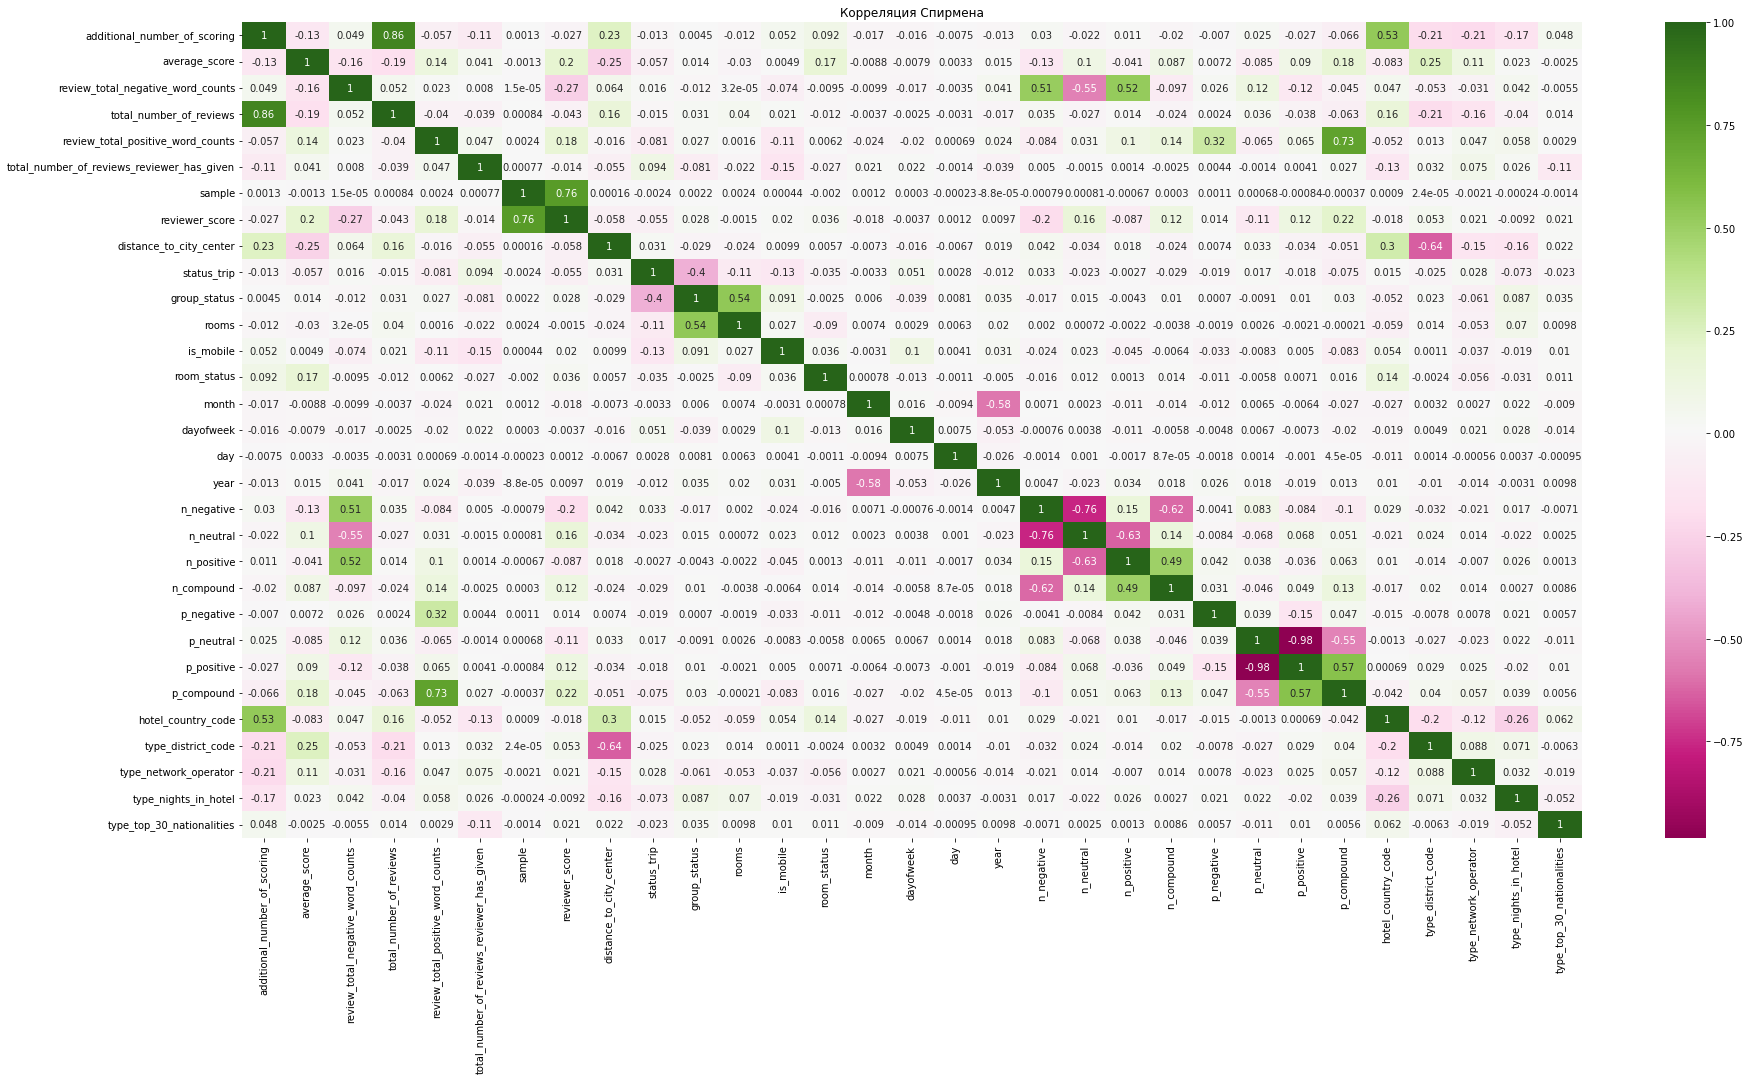

In [1108]:
# построим тепловую матрицу корреляций на стандартизированных данных
# поскольку у нас много признаков и мы не знаем какое между ними распределение воспользуемся корреляцией Спирмена
fig, ax = plt.subplots(figsize=(30, 15))
sns.heatmap(data_scaled.corr(method = 'spearman'), annot = True, cmap='PiYG')
plt.title('Корреляция Спирмена')

Text(0.5, 1.0, 'Корреляция Спирмена')

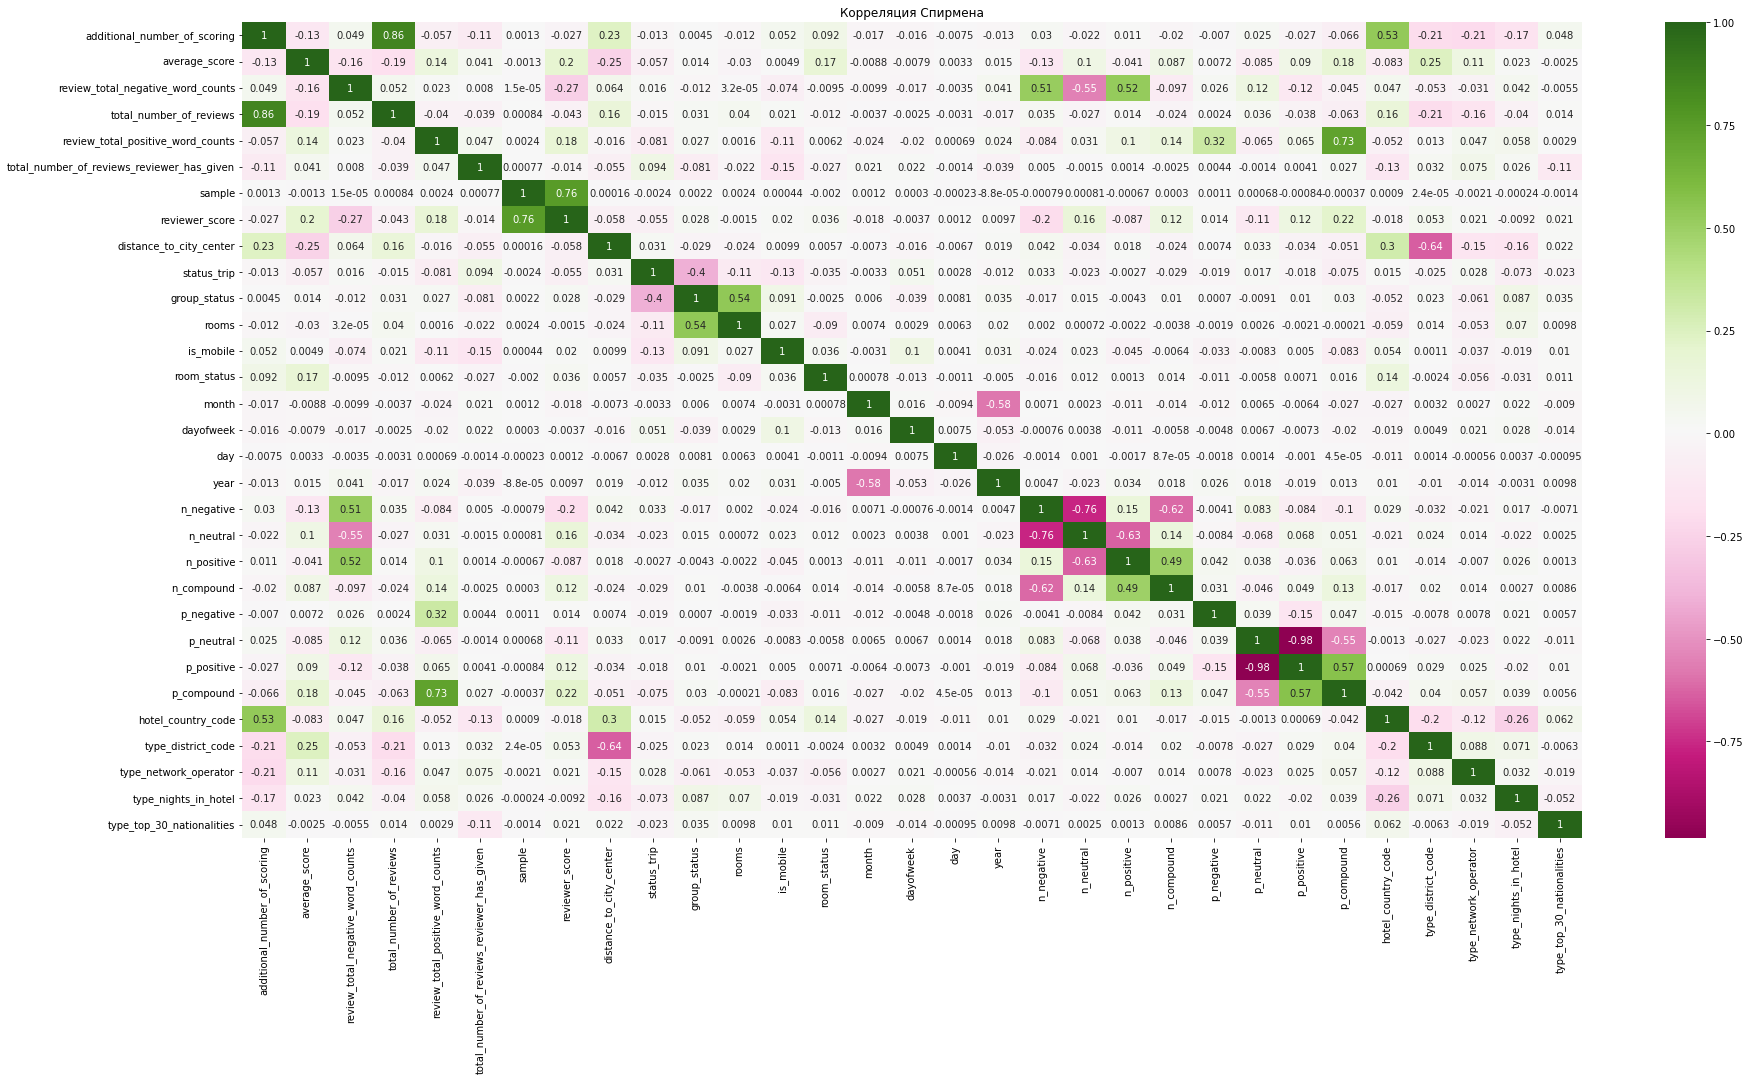

In [1109]:
# построим тепловую матрицу корреляций на нестандартизированных данных
# поскольку у нас много признаков и мы не знаем какое между ними распределение воспользуемся корреляцией Спирмена
fig, ax = plt.subplots(figsize=(30, 15))
sns.heatmap(data.corr(method = 'spearman'), annot = True, cmap='PiYG')
plt.title('Корреляция Спирмена')

Я не вижу разница между стандартизированными и не стандартизированными данными. Поэтому,  продолжу работу со своим датасетом. Не уверена, что эти данные нужно стандартизировать или нормализовать. 

In [1110]:
# имеется сильная прямая зависимость между признаками "additional_number_of_scoring" и "total_number_of_reviews", удалим один из этих признаков
# также видна зависимость в группе приззнаков, основанных на семантическом анализе отзывов, удалим 'p_positive',  'n_negative'
 
data.drop(['additional_number_of_scoring', 'p_positive', 'n_negative'], axis=1 , inplace=True)
data.head(3)

,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,sample,reviewer_score,distance_to_city_center,status_trip,group_status,...,n_positive,n_compound,p_negative,p_neutral,p_compound,hotel_country_code,type_district_code,type_network_operator,type_nights_in_hotel,type_top_30_nationalities
0,8.1,52,16670,62,1,0,0.0,7.798132,1,2,...,0.125,-0.0554,0.0,0.671,0.9615,2,0,41,12,28
1,8.6,10,5018,0,7,0,0.0,4.190587,1,3,...,0.000,-0.2960,0.0,1.000,0.0000,3,0,41,1,2
2,8.3,3,351,5,15,0,0.0,1.754801,2,1,...,0.000,0.0000,0.0,0.260,0.6908,4,1,8,1,24


Text(0.5, 1.0, 'Корреляция Спирмена')

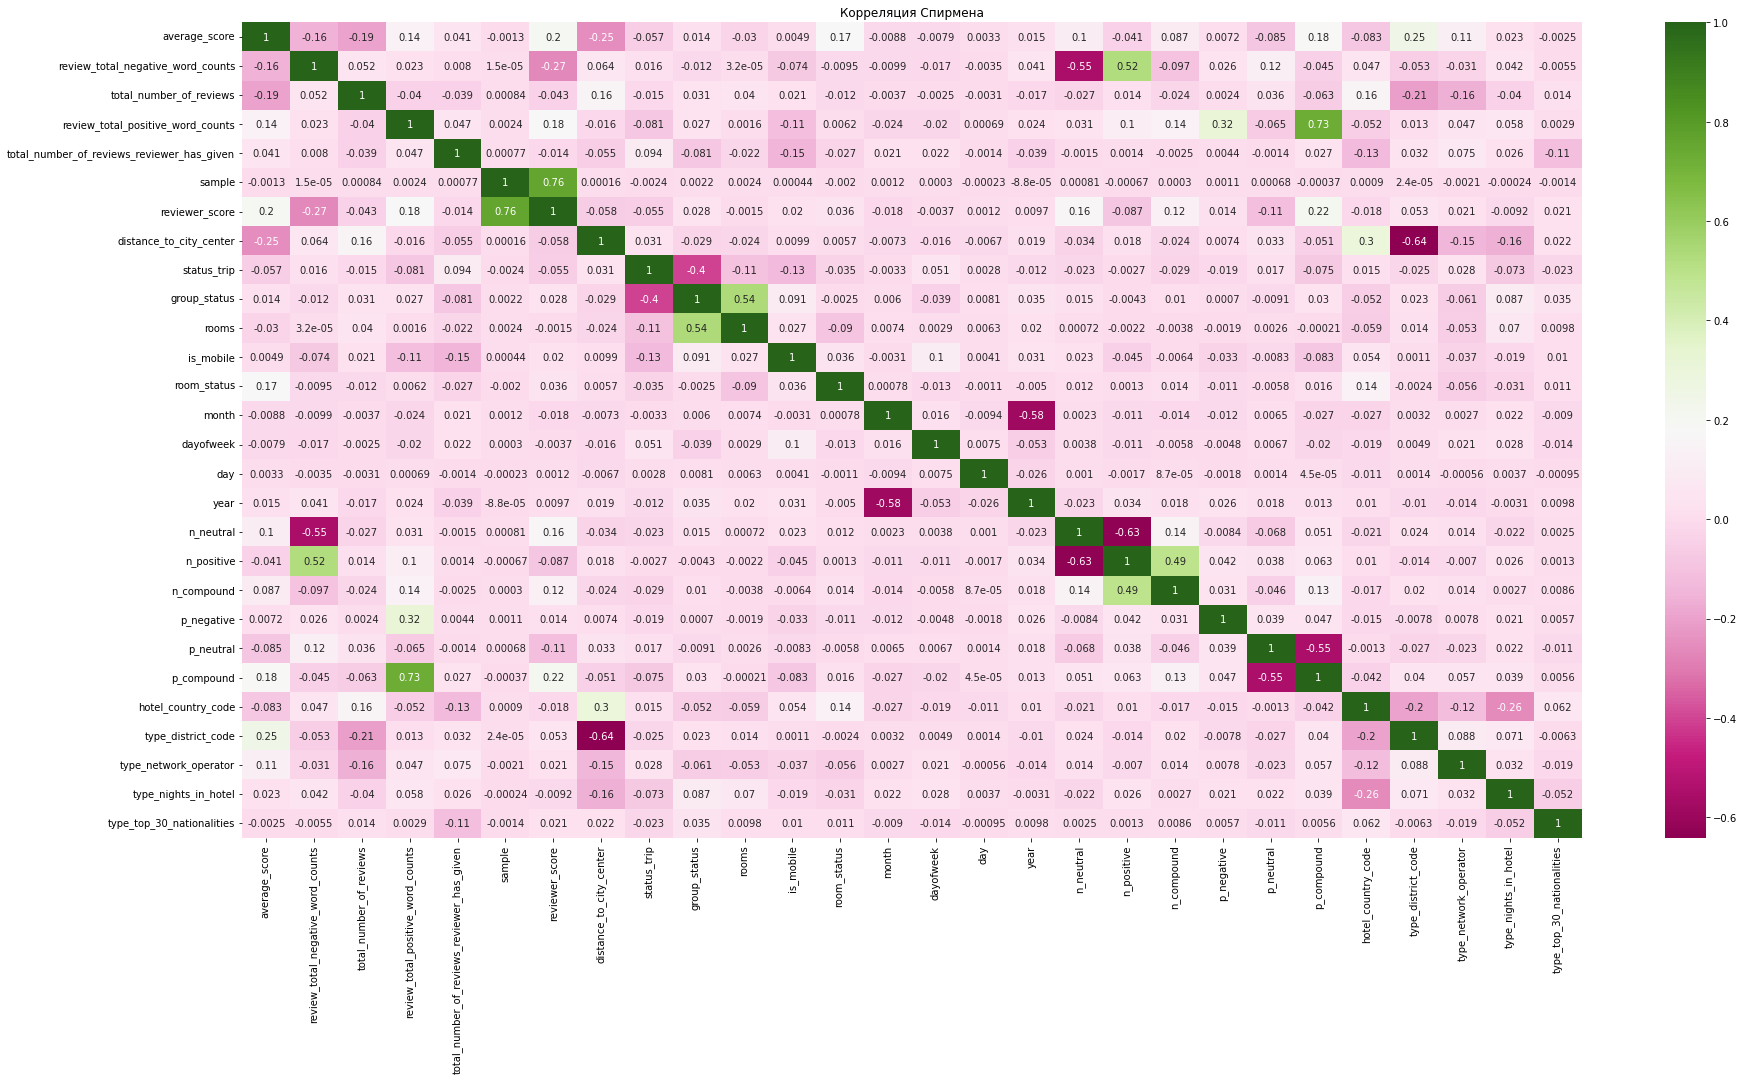

In [1111]:
# результат после удаления скоррелированных данных 
fig, ax = plt.subplots(figsize=(30, 15))
sns.heatmap(data.corr(method = 'spearman'), annot = True, cmap='PiYG')
plt.title('Корреляция Спирмена')

In [1112]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 28 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   average_score                               515738 non-null  float64
 1   review_total_negative_word_counts           515738 non-null  int64  
 2   total_number_of_reviews                     515738 non-null  int64  
 3   review_total_positive_word_counts           515738 non-null  int64  
 4   total_number_of_reviews_reviewer_has_given  515738 non-null  int64  
 5   sample                                      515738 non-null  int64  
 6   reviewer_score                              515738 non-null  float64
 7   distance_to_city_center                     515738 non-null  float64
 8   status_trip                                 515738 non-null  int64  
 9   group_status                                515738 non-null  int64  
 

#### Проведем оценку значимости признаков. Воспользуемся для оценки дисперсионным анализом ANOVA. 

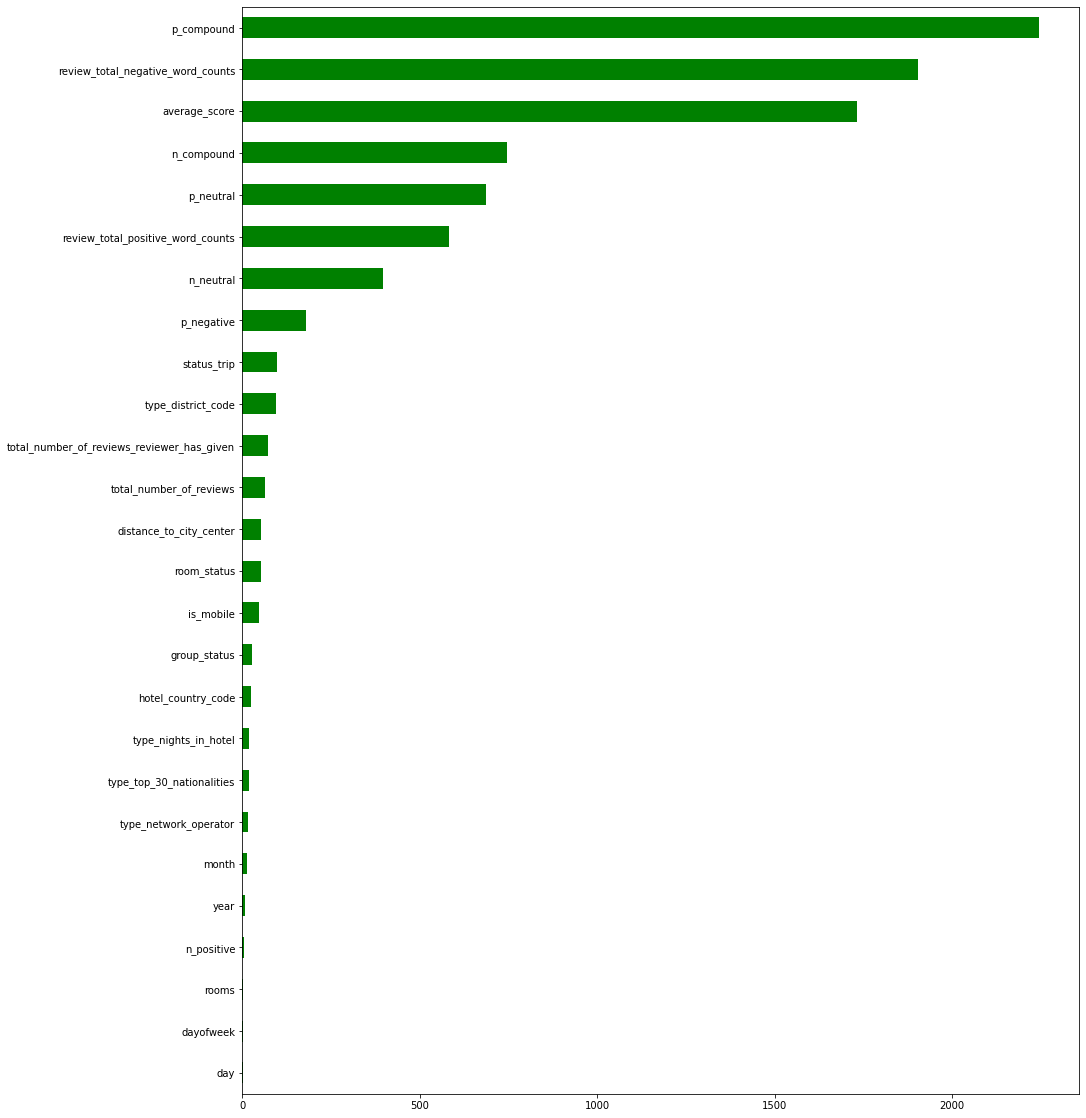

In [1113]:
y = data.query('sample == 1').drop(['sample'], axis=1).reviewer_score.values
X = data.query('sample == 1').drop(['sample', 'reviewer_score'], axis=1)

# визуализируем результат анализа значимости:
imp_num = pd.Series(f_classif(X[X.columns], y)[0], index = X.columns)
imp_num.sort_values(inplace = True)

fig5, ax5 = plt.subplots(figsize=(15, 20))
imp_num.plot(kind = 'barh', color='green');

#### Удалим признаки, которые не оказывают никакого влияния на корреляцию целевого признака

In [1114]:
data.drop(['day', 'dayofweek','rooms'], axis=1 , inplace=True)

In [1115]:
data.nunique(dropna=False)

average_score                                    34
review_total_negative_word_counts               402
total_number_of_reviews                        1142
review_total_positive_word_counts               365
total_number_of_reviews_reviewer_has_given      198
sample                                            2
reviewer_score                                   38
distance_to_city_center                        1488
status_trip                                       3
group_status                                      3
is_mobile                                         2
room_status                                       2
month                                            12
year                                              3
n_neutral                                       849
n_positive                                      780
n_compound                                    15789
p_negative                                      654
p_neutral                                       916
p_compound  

# 5. ПОСТОРОЕНИЕ МОДЕЛИ

<AxesSubplot:>

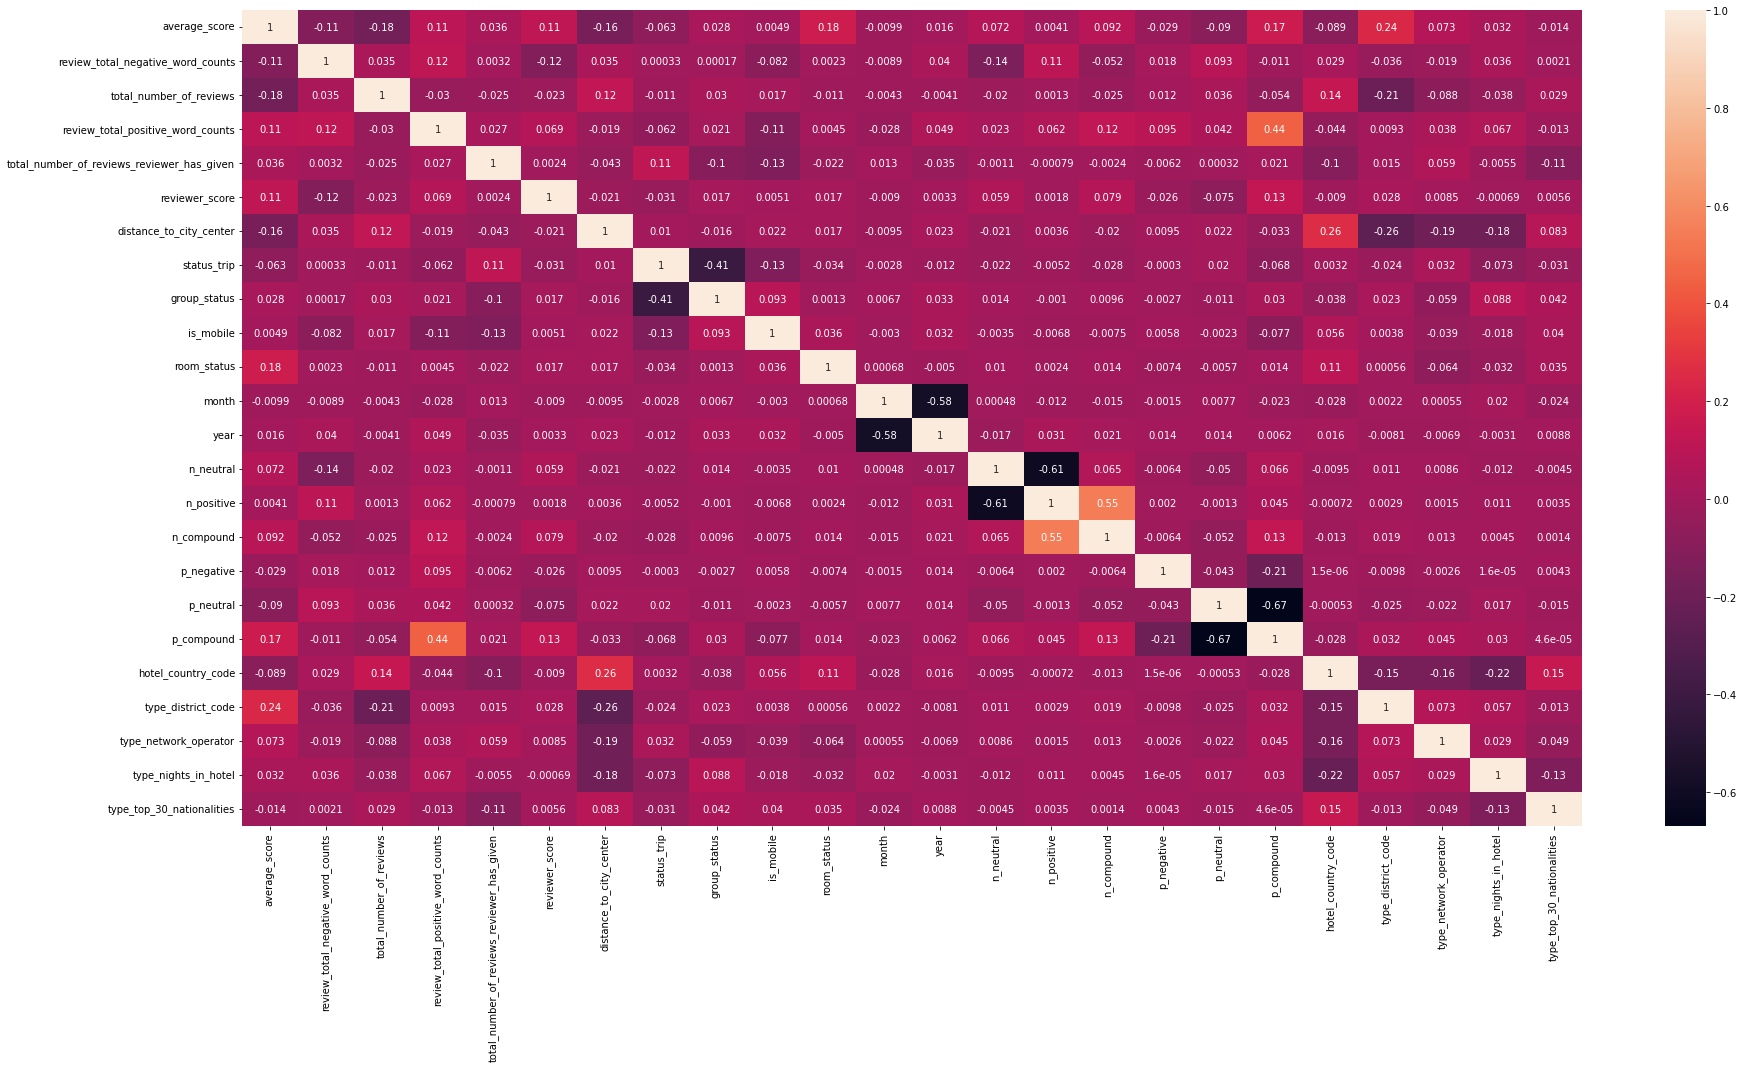

In [1116]:
plt.rcParams['figure.figsize'] = (30, 15)
sns.heatmap(data.drop(['sample'], axis=1).corr(), annot=True)

In [1117]:
# убираем признаки которые еще не успели обработать, 
# модель на признаках с dtypes "object" обучаться не будет, просто выберим их и удалим
#object_columns = [s for s in data.columns if data[s].dtypes == 'object']
#data.drop(object_columns, axis = 1, inplace=True)

In [1118]:
#data.info()

In [1119]:
# Теперь выделим тестовую часть
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

y = train_data.reviewer_score.values            # наш таргет
X = train_data.drop(['reviewer_score'], axis=1)

In [1120]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [1121]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((128935, 24), (386803, 24), (386803, 23), (309442, 23), (77361, 23))

In [1122]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [1123]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [1124]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.5min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.6s finished


In [1125]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Percentage Error (MAPE) и показывает среднее отклонение предсказанных значений от фактических.
def mean_absolute_percentage_error(y_tr, y_pr):
    """Получение средней абсолютной ошибки"""
    y_tr, y_pr = np.array(y_tr), np.array(y_pr)
    return np.mean(np.abs((y_tr - y_pr) / y_tr)) * 100

print('MAPE:', round(mean_absolute_percentage_error(y_test, y_pred), 2))



MAPE: 12.52


In [1126]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAPE:', metrics.mean_absolute_error(y_test, y_pred))

MAPE: 0.8784006324092177


<AxesSubplot:>

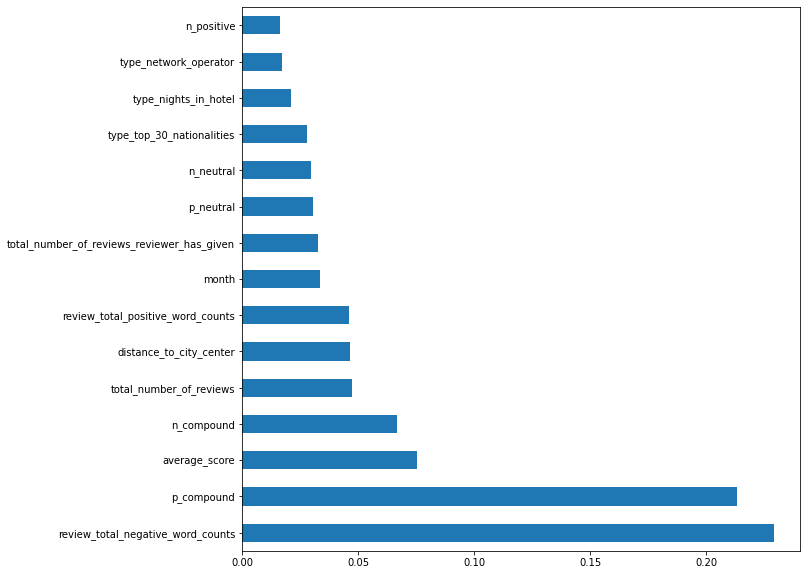

In [1127]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

In [1128]:
test_data.sample(10)

,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,distance_to_city_center,status_trip,group_status,is_mobile,...,n_positive,n_compound,p_negative,p_neutral,p_compound,hotel_country_code,type_district_code,type_network_operator,type_nights_in_hotel,type_top_30_nationalities
72078,8.3,33,1719,0,2,0.0,5.080821,1,2,1,...,0.000,0.0000,0.000,1.000,0.0000,5,0,41,12,14
5784,8.4,0,1479,7,1,0.0,0.962690,1,3,1,...,0.000,0.0000,0.000,0.346,0.8204,5,1,8,12,28
61436,8.3,0,2200,35,9,0.0,4.006913,1,3,1,...,0.000,0.0000,0.000,0.729,0.8766,1,0,9,1,5
98495,8.2,0,2836,19,3,0.0,1.813632,1,3,0,...,0.000,0.0000,0.000,0.348,0.9565,4,1,41,1,29
117163,9.0,32,4192,32,34,0.0,0.373622,1,2,1,...,0.000,0.0000,0.000,0.645,0.9124,2,1,41,23,0
15987,7.1,46,9086,26,6,0.0,7.275972,1,2,1,...,0.000,-0.8086,0.000,0.511,0.9593,5,0,41,1,28
110365,9.0,6,1283,21,1,0.0,3.406287,1,2,1,...,0.378,0.2075,0.101,0.524,0.8074,5,0,41,12,28
108706,8.9,0,406,5,6,0.0,1.557880,2,1,0,...,0.000,0.0000,0.000,0.423,0.6249,1,1,41,1,14
15553,7.5,11,2362,11,1,0.0,9.550036,1,3,1,...,0.107,-0.4767,0.000,0.721,0.4754,3,0,7,23,28
66434,8.3,21,1463,9,29,0.0,3.666243,1,1,1,...,0.212,-0.0231,0.000,1.000,0.0000,5,0,41,1,12


In [1129]:
test_data = test_data.drop(['reviewer_score'], axis=1)

In [1130]:
sample_submission

,reviewer_score,id
0,1,488440
1,10,274649
2,3,374688
3,10,404352
4,9,451596
...,...,...
128930,7,495812
128931,1,315577
128932,3,511968
128933,6,303386


In [1131]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    2.7s finished


In [1132]:
predict_submission

array([8.64 , 6.716, 8.482, ..., 8.319, 9.433, 7.165])

In [1133]:
list(sample_submission)

['reviewer_score', 'id']

In [1134]:
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,reviewer_score,id
0,8.640,488440
1,6.716,274649
2,8.482,374688
3,9.715,404352
4,9.563,451596
5,8.856,302161
6,7.920,317079
7,7.336,13963
8,8.152,159785
9,7.283,195089


## Вывод: в случае с моей моделью, мы видим, что из 15 признаков оказывающих максимальное влияние на модель 10 признаков были созданы в процессе обработки данных

In [1]:
# зафиксируем версию пакетов, для воспроизводимы воспроизводимости экспериментов:
!pip freeze > requirements.txt